In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
df = pd.read_csv("housing_az_sqm_azn.csv")

print(df.head())
print(df.info())


   PriceAZN  Bedrooms  Bathrooms    Sqm      City
0    225000         1          1   87.9      Baku
1     53200         3          2   45.0  Sumqayit
2    224100         3          2   81.2      Baku
3    318500         4          1  120.6      Baku
4    148900         5          1  126.9     Ganja
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PriceAZN   240 non-null    int64  
 1   Bedrooms   240 non-null    int64  
 2   Bathrooms  240 non-null    int64  
 3   Sqm        240 non-null    float64
 4   City       240 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 9.5+ KB
None


In [3]:
# 2. РАЗДЕЛЕНИЕ НА ПРИЗНАКИ (X) И ЦЕЛЬ (y)

y = df["PriceAZN"]

X = df.drop(columns=["PriceAZN"])

In [4]:
# 3. TRAIN / TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [5]:
# 4. ПРЕДОБРАБОТКА ПРИЗНАКОВ

numeric_features = ["Bedrooms", "Bathrooms", "Sqm"]
categorical_features = ["City"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)


categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Общий трансформер для таблицы X
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [6]:
# 5. ГРАДИЕНТНЫЙ БУСТИНГ

gbr_model = GradientBoostingRegressor(
    n_estimators=200,      # количество деревьев
    learning_rate=0.05,   # скорость обучения
    max_depth=3,          # глубина базовых деревьев
    random_state=42
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", gbr_model),
    ]
)

model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
# 6. ОЦЕНКА КАЧЕСТВА НА TRAIN/TEST

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

def print_metrics(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} MAE : {mae:.2f}")
    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} R^2 : {r2:.3f}")
    print("-" * 30)

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_test, y_test_pred, "Test")

Train MAE : 10196.05
Train RMSE: 14425.47
Train R^2 : 0.960
------------------------------
Test MAE : 14356.72
Test RMSE: 20159.73
Test R^2 : 0.904
------------------------------


In [8]:
# 7. КРОСС-ВАЛИДАЦИЯ (для более стабильной оценки)

cv_scores = cross_val_score(
    model,
    X,
    y,
    cv=5,
    scoring="r2"
)

print("CV R^2 scores:", cv_scores)
print("Mean CV R^2:", cv_scores.mean())

CV R^2 scores: [0.84840334 0.85752927 0.8942007  0.90801631 0.88886482]
Mean CV R^2: 0.8794028868685654


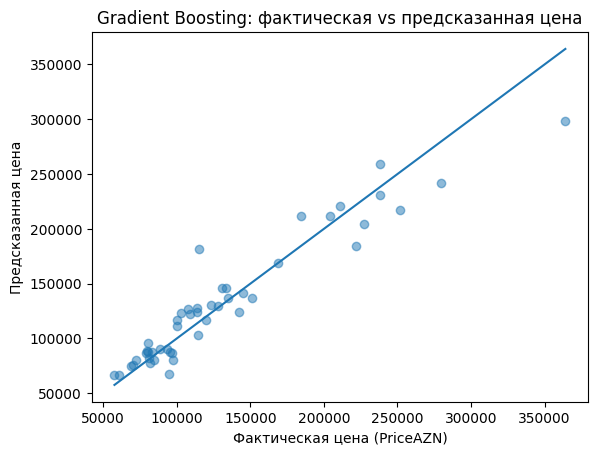

In [9]:
# 8. ВИЗУАЛИЗАЦИЯ: ФАКТ vs ПРОГНОЗ

plt.figure()
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel("Фактическая цена (PriceAZN)")
plt.ylabel("Предсказанная цена")
plt.title("Gradient Boosting: фактическая vs предсказанная цена")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.show()